# MCMAC results analysis

・'age' is absolute time

・'sep.kpc' is projected distance between two clusters

・'merger' shows the clusters is pre-merger or not

・'TSC_Catalog' shows Time Since Collision from Galaxy Cluster Merger Catalog. 

 We can calculate 
 
 TTC by "(1st apocentric passage's absolute time) - (TSC at 1st apocentric passage) - (dataframe's age) "
 
and 

TSC "(dataframe's age) - { (1st apocentric passage's absolute time) - (TSC at 1st apocentric passage)}".
 
 For simple dataframe, we replaced TTC to TSC by putting minus symbol
 
・'TSC0' shows Time Since Collision from MCMAC-pre-merger and MCMAC-post-merger

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import re
import seaborn as sns



In [2]:
results_default = []
results_weaklensing = []
difference_average = []

In [3]:
def extract_parameters(filename):
    # Define the pattern to extract the parameters from the filename
    pattern = r'zh_(\d+)to(\d+)_b([\d.]+)_z_MCMAC.txt'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    if match:
        # Extract the parameters
        param1 = match.group(1)
        param2 = match.group(2)
        b_value = match.group(3)
        
        # Format the parameters as "1:1 (b=0)"
        formatted_params = f"{param1}:{param2} (b={b_value})"
        
        return formatted_params
    else:
        return None

def pp_plot(data1, data2):
    # Sort both data sets
    ecdf1 = np.sort(data1)
    ecdf2 = np.sort(data2)
    
    # Calculate cumulative probabilities
    p1 = np.arange(1, len(ecdf1)+1) / len(ecdf1)
    p2 = np.arange(1, len(ecdf2)+1) / len(ecdf2)
    
    # Interpolate to find corresponding probabilities in the second data set
    p2_interp = np.interp(ecdf1, ecdf2, p2)
    
    # Plot P-P plot
    plt.figure(figsize=(8, 6))
    plt.plot(p1, p2_interp, 'o', label='Data')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
    plt.xlabel('Cumulative Probability (Data1)')
    plt.ylabel('Cumulative Probability (Data2)')
    plt.title('P-P Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


def plotImage(filename_default, filename_weaklensing_bias, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period):
    df_default = pd.read_csv(filename_default, sep='\t')
    df_selected_default = df_default[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper', 'TSC1', 'TSC1.lower', 'TSC1.upper']]
    df_selected_default = df_selected_default[df_selected_default['merger'] != 'pre']

    df_weaklensing_bias = pd.read_csv(filename_weaklensing_bias, sep='\t')
    df_selected_weaklensing_bias = df_weaklensing_bias[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper', 'TSC1', 'TSC1.lower', 'TSC1.upper']]
    df_selected_weaklensing_bias = df_selected_weaklensing_bias[df_selected_weaklensing_bias['merger'] != 'pre']

    # df_45degree = pd.read_csv(filename_45degree, sep='\t')
    # df_selected_45degree = df_45degree[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper', 'TSC1', 'TSC1.lower', 'TSC1.upper']]
    # df_selected_45degree = df_selected_45degree[df_selected_45degree['merger'] != 'pre']
    
    # Normalized_TSC
    # Catalog
    df_selected_default.loc[:, 'NormalizedTSC_Catalog'] = df_selected_default['delta.t'] / period_between_two_merger

    # 'age'が 'peak_period' 以下の場合, TSC0を使う
    mask = df_selected_default['age'] <= peak_period

    # default
    df_selected_default.loc[mask, 'NormalizedTSC_MCMAC_default'] = df_selected_default['TSC0'] / period_between_two_merger
    df_selected_default.loc[mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_default['TSC0.lower'] / period_between_two_merger
    df_selected_default.loc[mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_default['TSC0.upper'] / period_between_two_merger

    # 'age'が 'peak_period' より大きい場合,TSC1を使う
    df_selected_default.loc[~mask, 'NormalizedTSC_MCMAC_default'] = df_selected_default['TSC1'] / period_between_two_merger
    df_selected_default.loc[~mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_default['TSC1.lower'] / period_between_two_merger
    df_selected_default.loc[~mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_default['TSC1.upper'] / period_between_two_merger
        
    # 0-20 degree
    df_selected_weaklensing_bias.loc[mask, 'NormalizedTSC_MCMAC_default'] = df_selected_weaklensing_bias['TSC0'] / period_between_two_merger
    df_selected_weaklensing_bias.loc[mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_weaklensing_bias['TSC0.lower'] / period_between_two_merger
    df_selected_weaklensing_bias.loc[mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_weaklensing_bias['TSC0.upper'] / period_between_two_merger

    # 'age'が 'peak_period' より大きい場合,TSC1を使う
    df_selected_weaklensing_bias.loc[~mask, 'NormalizedTSC_MCMAC_default'] = df_selected_weaklensing_bias['TSC1'] / period_between_two_merger
    df_selected_weaklensing_bias.loc[~mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_weaklensing_bias['TSC1.lower'] / period_between_two_merger
    df_selected_weaklensing_bias.loc[~mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_weaklensing_bias['TSC1.upper'] / period_between_two_merger
        
    # # 0-60 degree
    # df_selected_45degree.loc[mask, 'NormalizedTSC_MCMAC_default'] = df_selected_45degree['TSC0'] / period_between_two_merger
    # df_selected_45degree.loc[mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_45degree['TSC0.lower'] / period_between_two_merger
    # df_selected_45degree.loc[mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_45degree['TSC0.upper'] / period_between_two_merger

    # # 'age'が 'peak_period' より大きい場合,TSC1を使う
    # df_selected_45degree.loc[~mask, 'NormalizedTSC_MCMAC_default'] = df_selected_45degree['TSC1'] / period_between_two_merger
    # df_selected_45degree.loc[~mask, 'NormalizedTSC_MCMAC_default.lower'] = df_selected_45degree['TSC1.lower'] / period_between_two_merger
    # df_selected_45degree.loc[~mask, 'NormalizedTSC_MCMAC_default.upper'] = df_selected_45degree['TSC1.upper'] / period_between_two_merger
    
    difference_list = df_selected_default['TSC0'] - df_selected_weaklensing_bias['TSC0']

    # 相対誤差の計算
    df_selected_default = df_selected_default.copy()
    df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['NormalizedTSC_MCMAC_default'] - df_selected_default['NormalizedTSC_Catalog']
    
    df_selected_weaklensing_bias = df_selected_weaklensing_bias.copy()
    df_selected_weaklensing_bias.loc[:,'Absolute Residual'] = df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default'] - df_selected_default['NormalizedTSC_Catalog']
    
    # df_selected_45degree = df_selected_45degree.copy()
    # df_selected_45degree.loc[:,'Absolute Residual'] = df_selected_45degree['NormalizedTSC_MCMAC_default'] - df_selected_default['NormalizedTSC_Catalog']
    

    # プロットスタイルの設定
    plt.style.use('ggplot')

    # 図とグリッドスペックの作成
    fig = plt.figure(figsize=(12, 18))
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])

    # delta.t の範囲でフィルタリング
    df_zoomed = df_selected_default[(df_selected_default['delta.t'] >= -0.3) & (df_selected_default['delta.t'] <= 0.3)]
    df_zoomed_20degree = df_selected_weaklensing_bias[(df_selected_weaklensing_bias['delta.t'] >= -0.3) & (df_selected_weaklensing_bias['delta.t'] <= 0.3)]
    # df_zoomed_45degree = df_selected_45degree[(df_selected_45degree['delta.t'] >= -0.3) & (df_selected_45degree['delta.t'] <= 0.3)]

    # 最上部プロット (拡大図)
    ax_zoom = fig.add_subplot(gs[0])
    line_zoom2 = ax_zoom.errorbar(df_zoomed['delta.t'], df_zoomed['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_zoomed['NormalizedTSC_MCMAC_default'] - df_zoomed['NormalizedTSC_MCMAC_default.lower']), np.abs(df_zoomed['NormalizedTSC_MCMAC_default.upper'] - df_zoomed['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='Normalized TSC from MCMAC')
    # line_zoom4 = ax_zoom.errorbar(df_zoomed_45degree['delta.t'], df_zoomed_45degree['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_zoomed_45degree['NormalizedTSC_MCMAC_default'] - df_zoomed_45degree['NormalizedTSC_MCMAC_default.lower']), np.abs(df_zoomed_45degree['NormalizedTSC_MCMAC_default.upper'] - df_zoomed_45degree['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='blue', label='Normalized TSC from MCMAC with 0-60 degree')
    line_zoom3 = ax_zoom.errorbar(df_zoomed_20degree['delta.t'], df_zoomed_20degree['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_zoomed_20degree['NormalizedTSC_MCMAC_default'] - df_zoomed_20degree['NormalizedTSC_MCMAC_default.lower']), np.abs(df_zoomed_20degree['NormalizedTSC_MCMAC_default.upper'] - df_zoomed_20degree['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='Normalized TSC from MCMAC with weak lensing mass bias')
    # line_zoom1 = ax_zoom.scatter(df_zoomed['delta.t'], df_zoomed['NormalizedTSC_Catalog'], label='Normalized TSC from Catalog', color='black', s=64, marker='^')

    # 縦の点線を追加
    ax_zoom.axvline(color='black', linestyle='--')
    ax_zoom.axhline(color='black', linestyle='--')


    ax_zoom.set_xlabel('delta.t (TSC from catalogue)')
    ax_zoom.set_ylabel('Normalized TSC from Catalog')
    ax_zoom.set_xlim(zoom_x_range[0], zoom_x_range[1])
    ax_zoom.set_ylim(zoom_y_range[0], zoom_y_range[1])

    # 二つ目のy軸としてTSC from MCMACを追加
    ax_zoom2 = ax_zoom.twinx()
    ax_zoom2.set_ylabel('Normalized TSC from MCMAC')
    ax_zoom2.set_ylim(zoom_y_range[0], zoom_y_range[1])

    # lines_zoom = [line_zoom1, line_zoom2, line_zoom3, line_zoom4]
    lines_zoom = [line_zoom2, line_zoom3]
    labels_zoom = [l.get_label() for l in lines_zoom]
    ax_zoom.legend(lines_zoom, labels_zoom, loc='upper left')

    # 上部プロット
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xlabel('Absolute age (Gyr)')
    ax1.set_ylabel('Normalized TSC from Catalog')
    ax1.set_xlim(plot1_x_range[0], plot1_x_range[1])
    ax1.set_ylim(plot1_y_range[0], plot1_y_range[1])
    ax1.axvline(x=absolute_merge_time, color='black', linestyle='--')
    ax1.axhline(color='black', linestyle='--')

    ax2 = ax1.twinx()
    line2 = ax2.errorbar(df_selected_default['age'], df_selected_default['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_selected_default['NormalizedTSC_MCMAC_default'] - df_selected_default['NormalizedTSC_MCMAC_default.lower']), np.abs(df_selected_default['NormalizedTSC_MCMAC_default.upper'] - df_selected_default['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='Normalized TSC from MCMAC')
    # line8 = ax2.errorbar(df_selected_45degree['age'], df_selected_45degree['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_selected_45degree['NormalizedTSC_MCMAC_default'] - df_selected_45degree['NormalizedTSC_MCMAC_default.lower']), np.abs(df_selected_45degree['NormalizedTSC_MCMAC_default.upper'] - df_selected_45degree['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='blue', label='Normalized TSC from MCMAC with 0-60 degree')
    line3 = ax2.errorbar(df_selected_weaklensing_bias['age'], df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default'], yerr=[np.abs(df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default'] - df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default.lower']), np.abs(df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default.upper'] - df_selected_weaklensing_bias['NormalizedTSC_MCMAC_default'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='Normalized TSC from MCMAC with weak lensing mass bias')
    # line1 = ax1.scatter(df_selected_default['age'], df_selected_default['NormalizedTSC_Catalog'], label='Normalized TSC from Catalog', color='black', s=64, marker='^')


    ax2.set_ylabel('Normalized TSC from MCMAC')
    ax2.set_ylim(plot1_y_range[0], plot1_y_range[1])

    ax7 = ax1.twiny()
    ax7.set_xlim(ax1.get_xlim())
    ax7.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax7.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax7.set_xlabel('delta.t (TSC from catalogue)')

    # lines = [line1, line2, line3, line8]
    lines = [line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # 中部プロット
    ax3 = fig.add_subplot(gs[2])
    line4 = ax3.plot(df_selected_default['age'], difference_list, 'y-', label='Difference', marker='o', markersize=5)
    # line4 = ax3.plot(df_selected_default['age'], df_selected_default['Absolute Residual'], 'r-', label='Default', marker='o', markersize=5)
    # line5 = ax3.plot(df_selected_weaklensing_bias['age'], df_selected_weaklensing_bias['Absolute Residual'], '-', label='With weak lensing mass bias', marker='o', markersize=5, color='green')
    # line9 = ax3.plot(df_selected_45degree['age'], df_selected_45degree['Absolute Residual'], '-', label='0-60 degree', marker='o', markersize=5, color='blue')

    ax3.set_xlabel('Absolute age (Gyr)')
    ax3.set_ylabel('Absolute Residual (Gyr)')
    ax3.set_xlim(plot2_x_range[0], plot2_x_range[1])
    ax3.set_ylim(plot2_y_range[0], plot2_y_range[1])
    ax3.axhline(color='black', linestyle='--')
    ax3.axvline(x=absolute_merge_time, color='black', linestyle='--')

    ax6 = ax3.twiny()
    ax6.set_xlim(ax3.get_xlim())
    ax6.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax6.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax6.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax6.axvline(x=0.00, color='black', linestyle='--')

    # lines_mid = [line4[0], line5[0], line9[0]]
    lines_mid = [line4[0]]
    labels_mid = [l.get_label() for l in lines_mid]
    ax3.legend(lines_mid, labels_mid, loc='upper left')

    # 下部プロット
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(df_selected_default['age'], df_selected_default['sep.kpc'], 'b-', label='Halo Separation', marker='o', markersize=5)
    ax4.set_xlabel('Absolute age (Gyr)')
    ax4.set_ylabel('Halo Separation (kpc)')
    ax4.set_xlim(plot3_x_range[0], plot3_x_range[1])
    ax4.set_ylim(plot3_y_range[0], plot3_y_range[1])
    ax4.axvline(x=absolute_merge_time, color='black', linestyle='--')


    ax5 = ax4.twiny()
    ax5.set_xlim(ax4.get_xlim())
    ax5.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax5.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax5.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax5.axvline(x=0.00, color='black', linestyle='--')

    # Calculate metrics
    mae_default = mean_absolute_error(df_selected_default['delta.t'], df_selected_default['TSC0'])
    rmse_default = np.sqrt(mean_squared_error(df_selected_default['delta.t'], df_selected_default['TSC0']))
    r2_default = r2_score(df_selected_default['delta.t'], df_selected_default['TSC0'])

    mae_weaklensing = mean_absolute_error(df_selected_weaklensing_bias['delta.t'], df_selected_weaklensing_bias['TSC0'])
    rmse_weaklensing = np.sqrt(mean_squared_error(df_selected_weaklensing_bias['delta.t'], df_selected_weaklensing_bias['TSC0']))
    r2_weaklensing = r2_score(df_selected_weaklensing_bias['delta.t'], df_selected_weaklensing_bias['TSC0'])

    # mae_60degree = mean_absolute_error(df_selected_45degree['delta.t'], df_selected_45degree['TSC0'])
    # rmse_60degree = np.sqrt(mean_squared_error(df_selected_45degree['delta.t'], df_selected_45degree['TSC0']))
    # r2_60degree = r2_score(df_selected_45degree['delta.t'], df_selected_45degree['TSC0'])


    plt.tight_layout()
    plt.show()

    filename_default = extract_parameters(filename_default)
    # Print metrics
    # print(f"Metrics for default angle:")
    # print(f"MAE: {mae_default}")
    # print(f"RMSE: {rmse_default}")
    # print(f"R²: {r2_default}")
    results_default.append({
        "filename": filename_default,
        "MAE": mae_default,
        "RMSE": rmse_default,
        "R²": r2_default
    })

    filename_weaklensing_bias = extract_parameters(filename_weaklensing_bias)
    # print(f"\nMetrics for 20-degree angle:")
    # print(f"MAE: {mae_weaklensing}")
    # print(f"RMSE: {rmse_weaklensing}")
    # print(f"R²: {r2_weaklensing}")
    results_weaklensing.append({
        "filename": filename_weaklensing_bias,
        "MAE": mae_weaklensing,
        "RMSE": rmse_weaklensing,
        "R²": r2_weaklensing
    })
    
    # filename_60degree = extract_parameters(filename_45degree)
    # results_0_60.append({
    #     "filename": filename_60degree,
    #     "MAE": mae_60degree,
    #     "RMSE": rmse_60degree,
    #     "R²": r2_60degree
    # })
    

## Mass ratio 1:1 b=0kpc

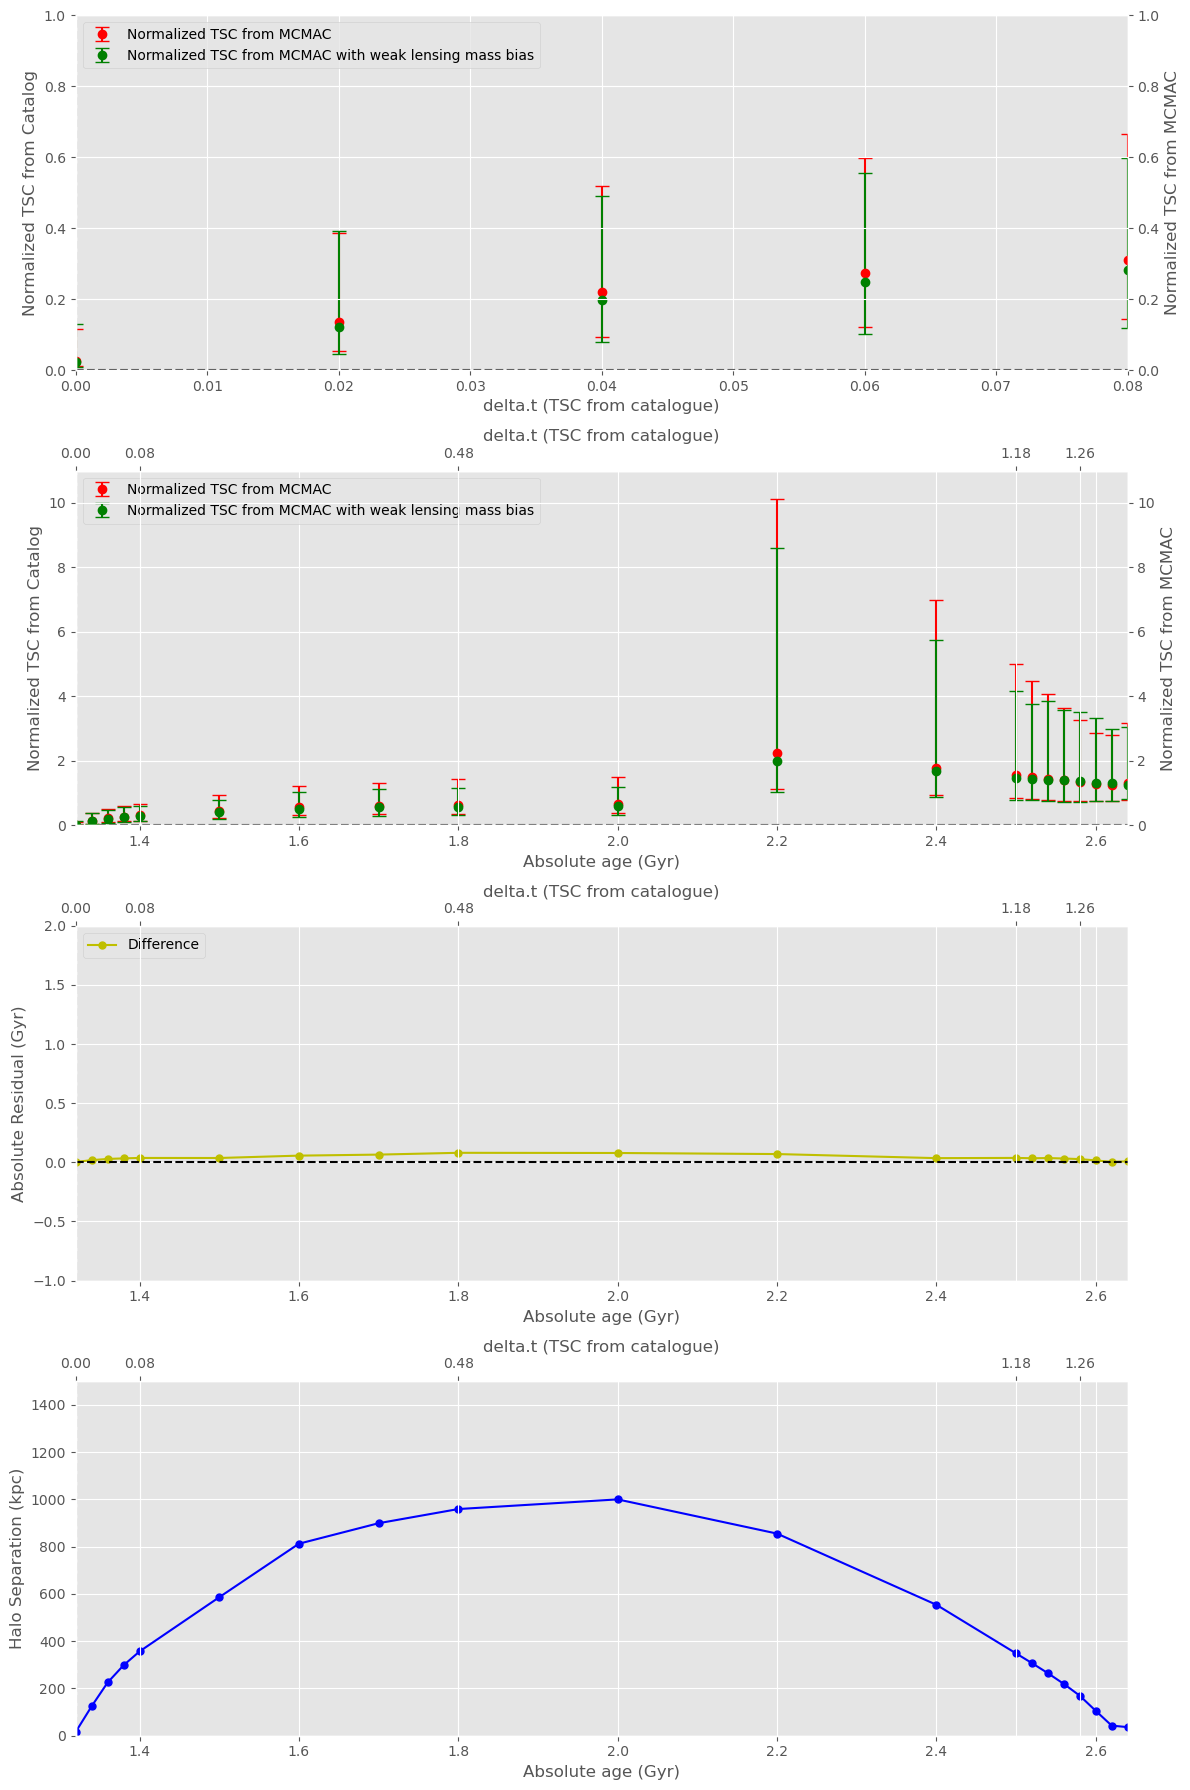

In [4]:
filename_default = '../output_default_2nd_pericentric_passages/zh_1to1_b0_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to1_b0_z_MCMAC.txt'

absolute_merge_time = 2 - 0.68
period_between_two_merger = 1.32
peak_period = 2
second_period = 2.64

zoom_x_range = [0, 0.08]
zoom_y_range = [0, 1]
plot1_x_range = [period_between_two_merger, second_period]
plot1_y_range = [0, 11]
plot2_x_range = [period_between_two_merger, second_period]
plot2_y_range = [-1, 2]
plot3_x_range = [period_between_two_merger, second_period]
plot3_y_range = [0, 1500]


plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:1 b=500kpc

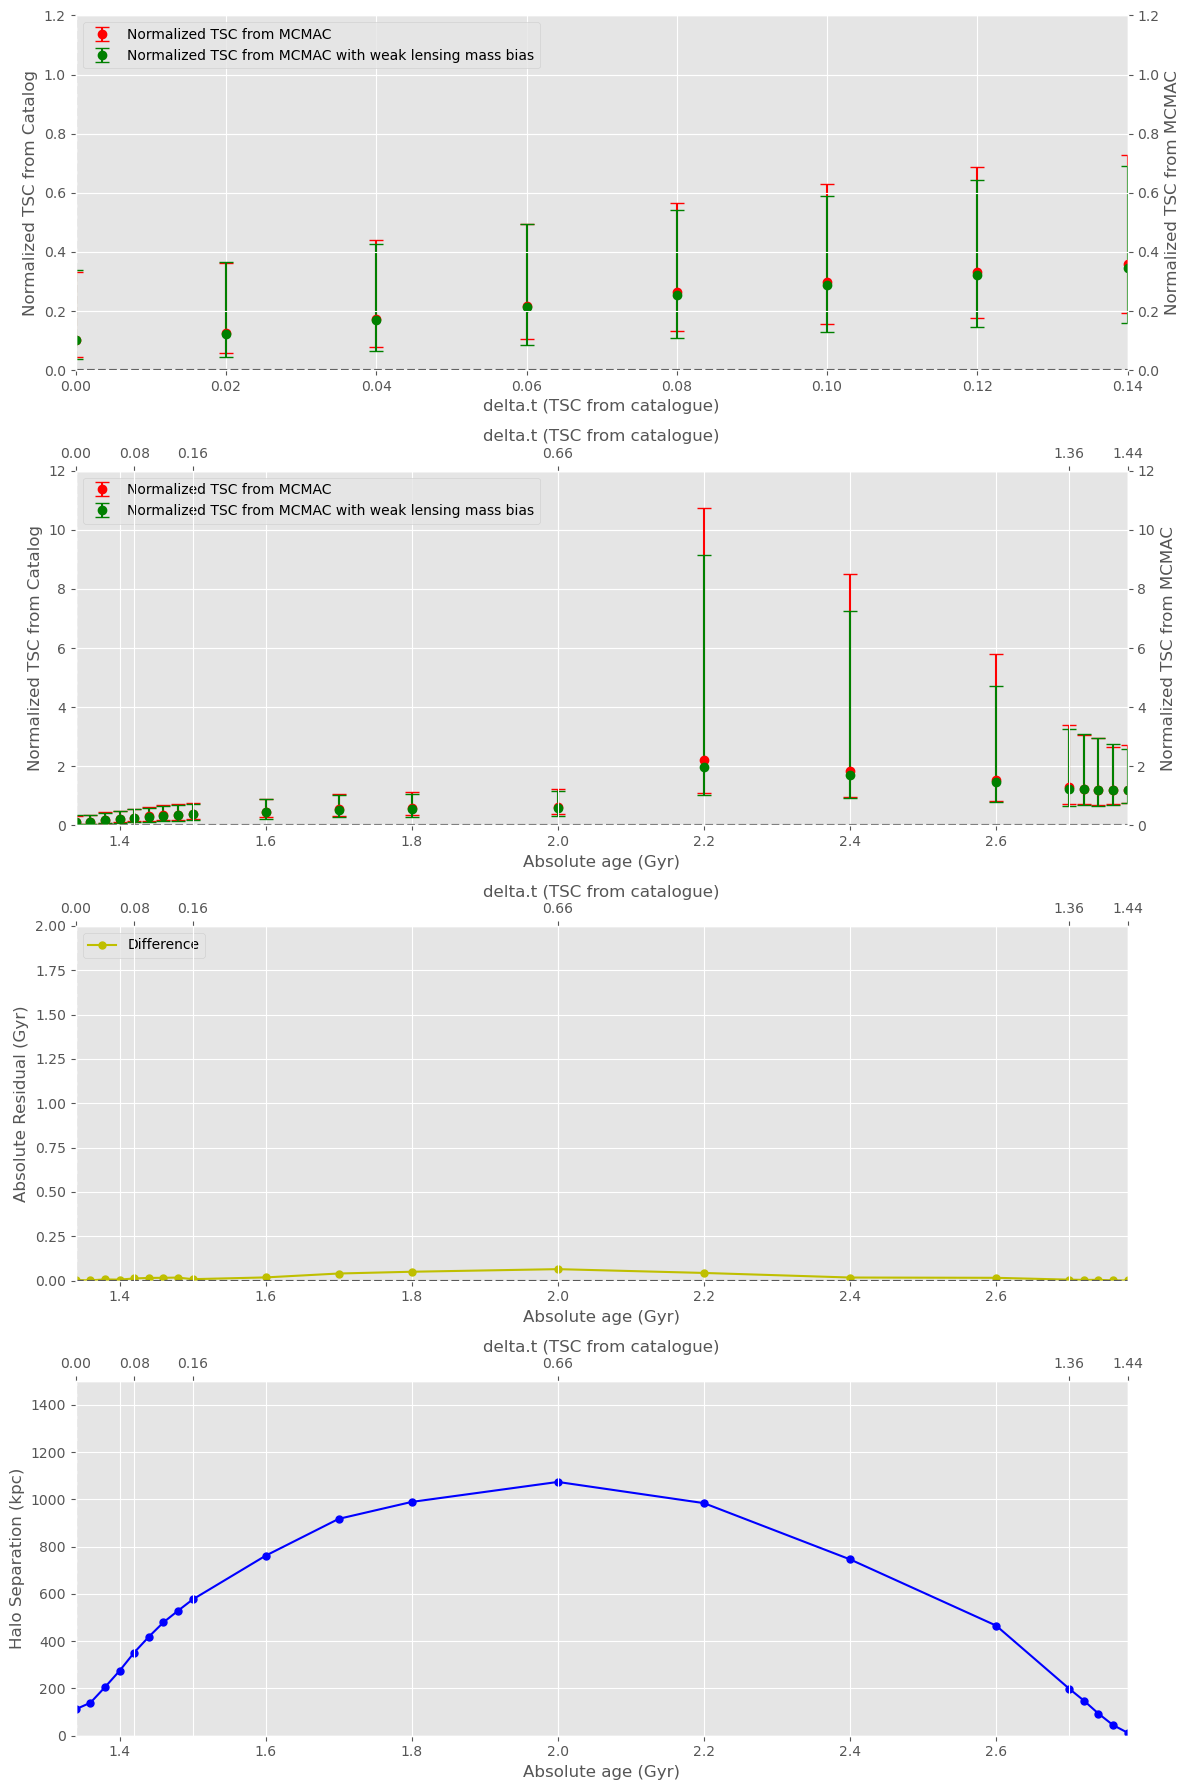

In [5]:
filename_default = '../output_default_2nd_pericentric_passages/zh_1to1_b0.5_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to1_b0.5_z_MCMAC.txt'

absolute_merge_time = 2 - 0.66
period_between_two_merger = 1.44
peak_period = 2
second_period = 2.78

zoom_x_range = [0, 0.14]
zoom_y_range = [0, 1.2]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 12]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [0, 2]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 1500]

plotImage(filename_default, filename_weaklensing,zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:1 b=1000kpc

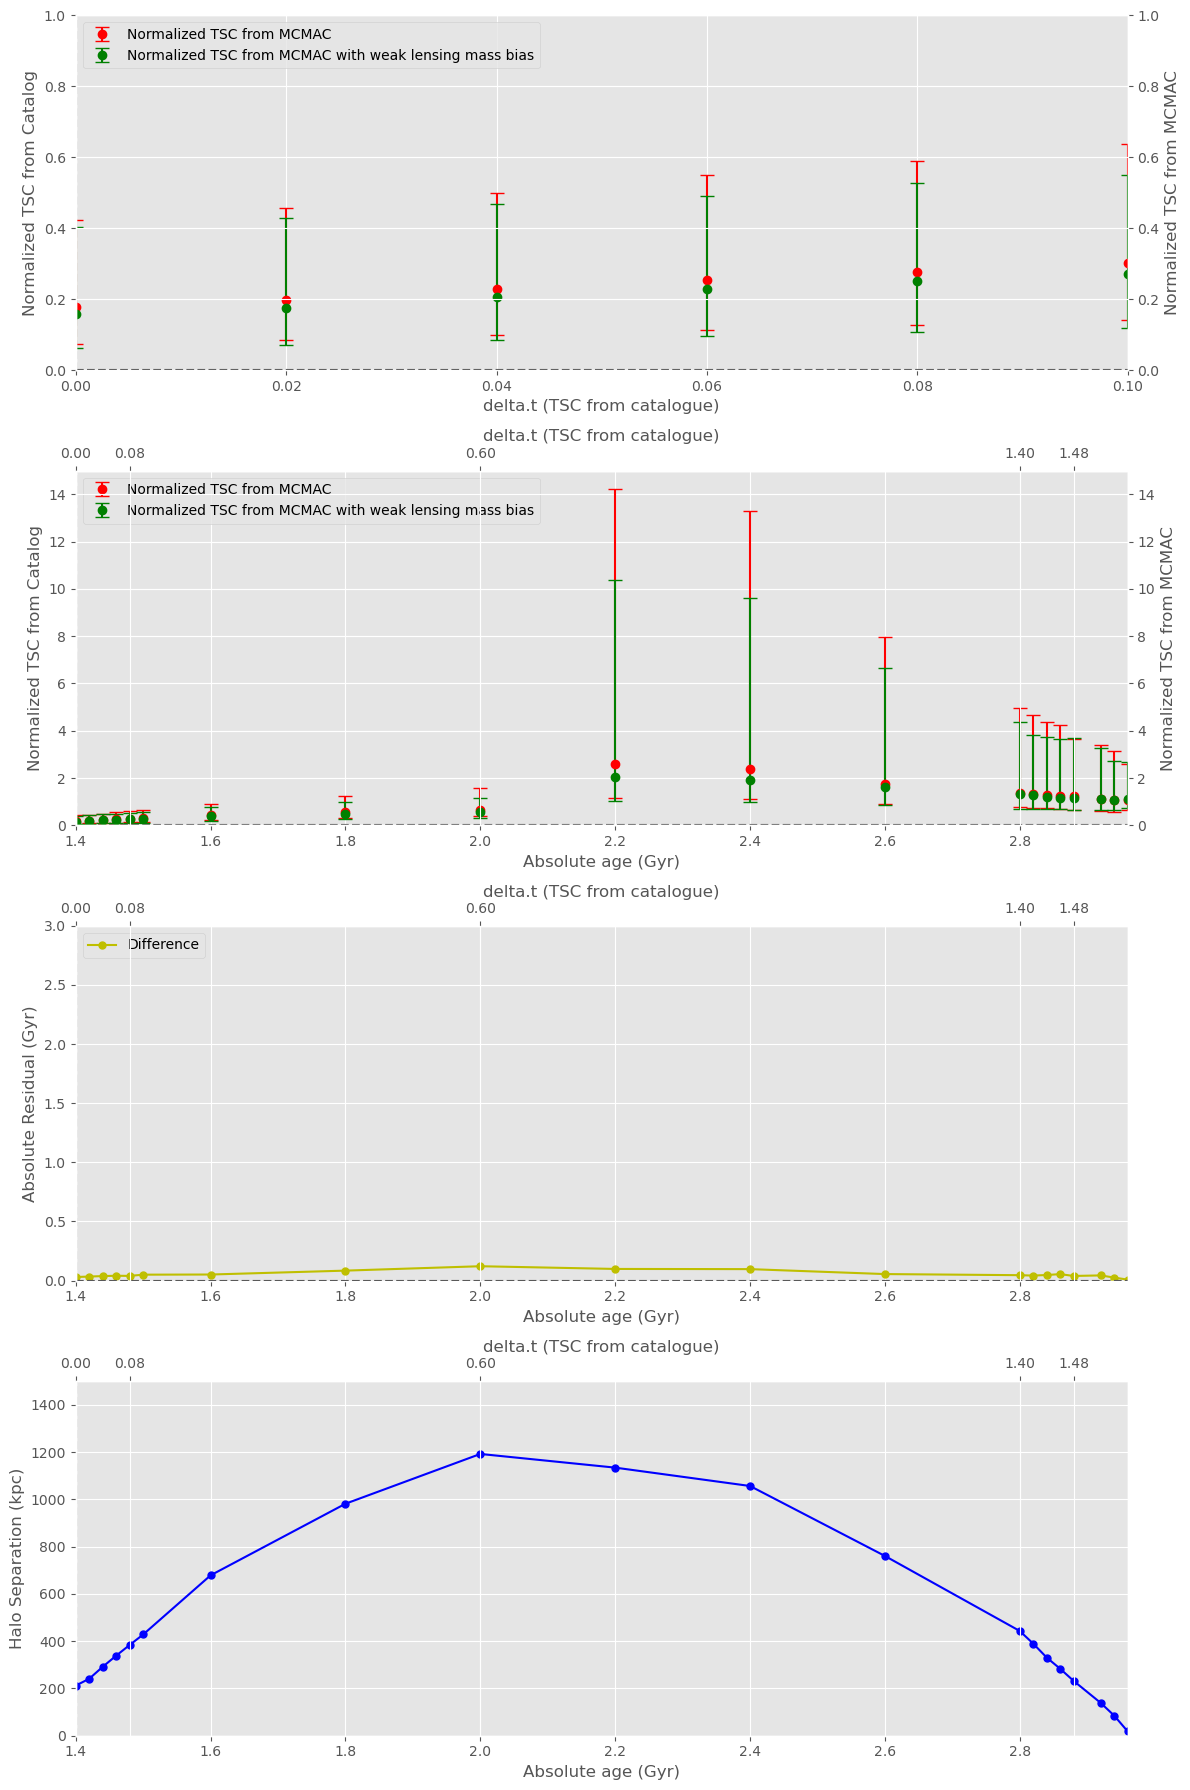

In [6]:
filename_default = '../output_default_2nd_pericentric_passages/zh_1to1_b1_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to1_b1_z_MCMAC.txt'

absolute_merge_time = 2 - 0.6
period_between_two_merger = 1.56
peak_period = 2
second_period = 2.96

zoom_x_range = [0, 0.1]
zoom_y_range = [0, 1]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 15]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [0, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 1500]


plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:3 b=0kpc

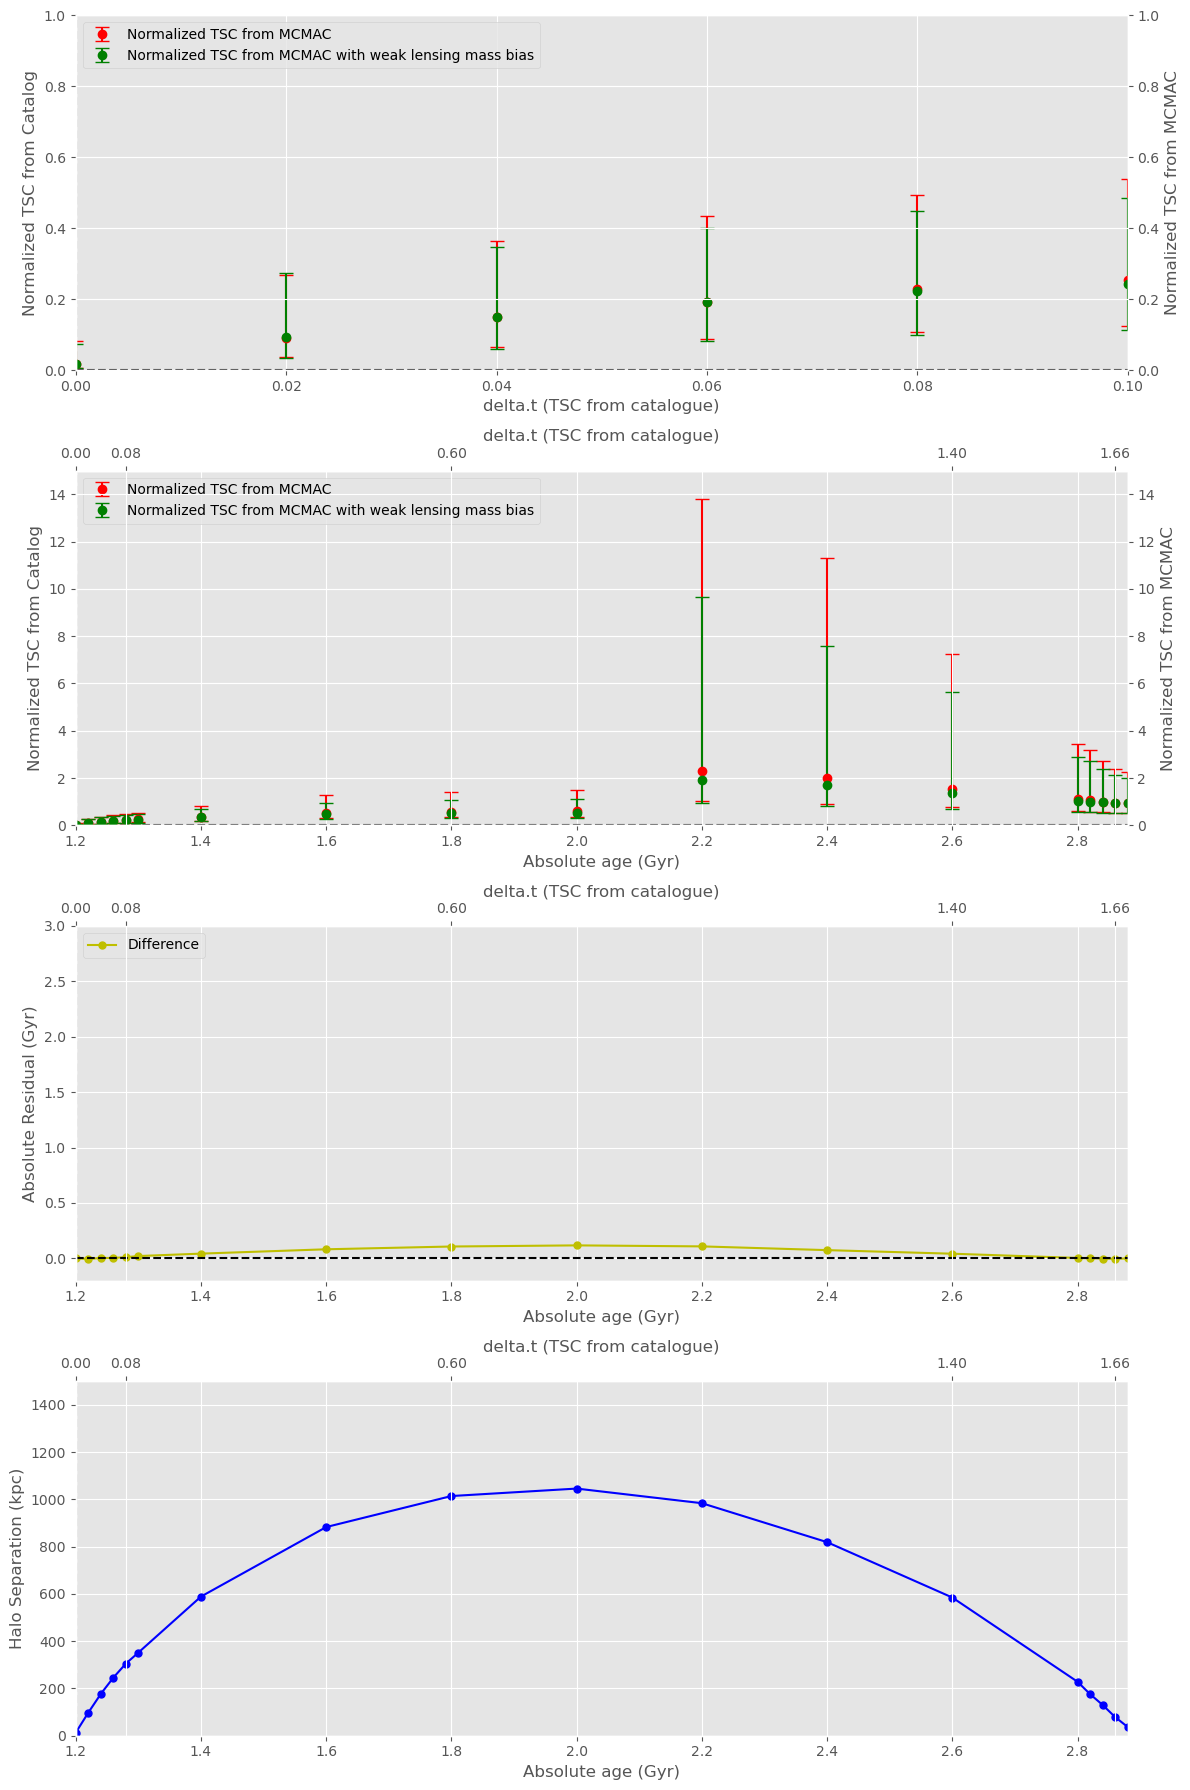

In [7]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to3_b0_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to3_b0_z_MCMAC.txt'

absolute_merge_time = 2 - 0.8
period_between_two_merger = 1.68
peak_period = 2
second_period = 2.88

zoom_x_range = [0, 0.1]
zoom_y_range = [0, 1]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 15]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-0.2, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 1500]


plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:3 b=500kpc

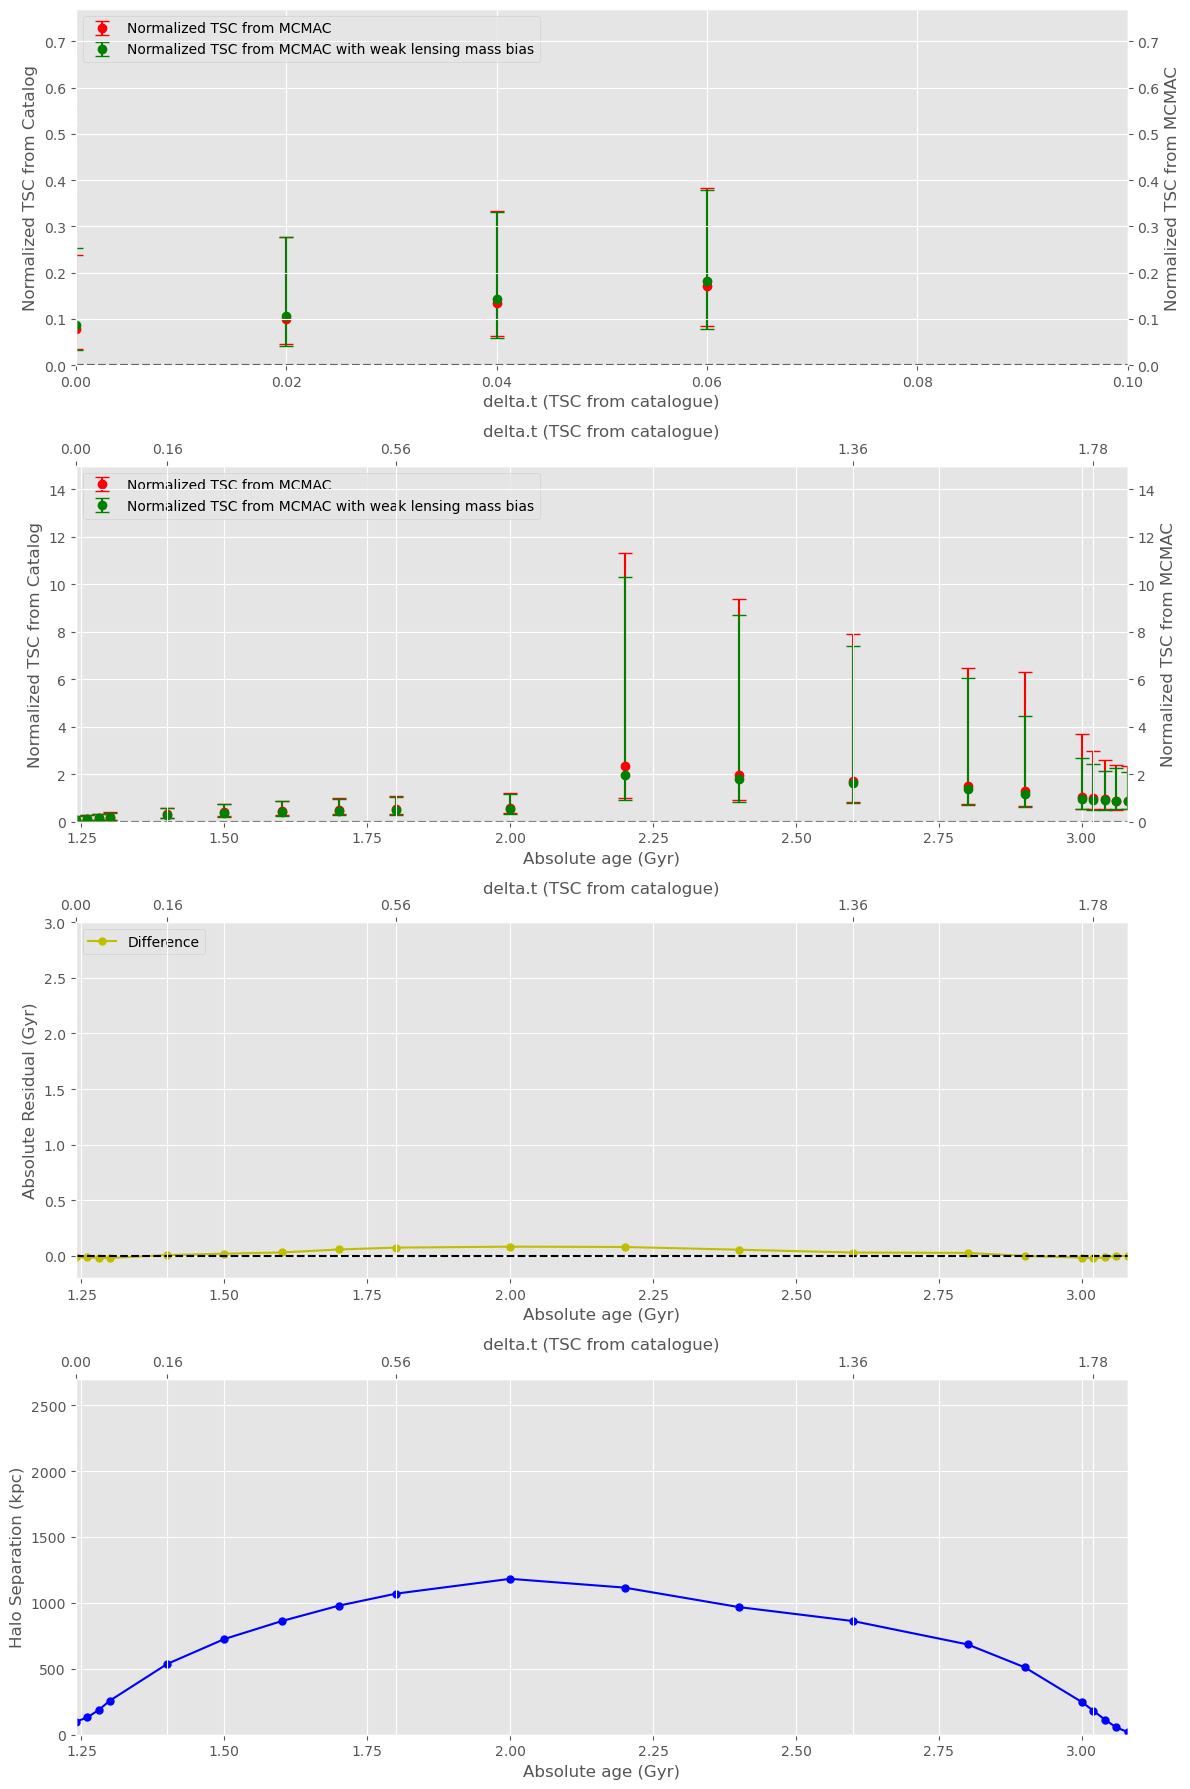

In [8]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to3_b0.5_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to3_b0.5_z_MCMAC.txt'
absolute_merge_time = 2 - 0.76
period_between_two_merger = 1.84
peak_period = 2
second_period = 3.08

zoom_x_range = [0, 0.1]
zoom_y_range = [0, 0.77]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 15]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-0.2, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 2700]


plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:3 b=1000kpc

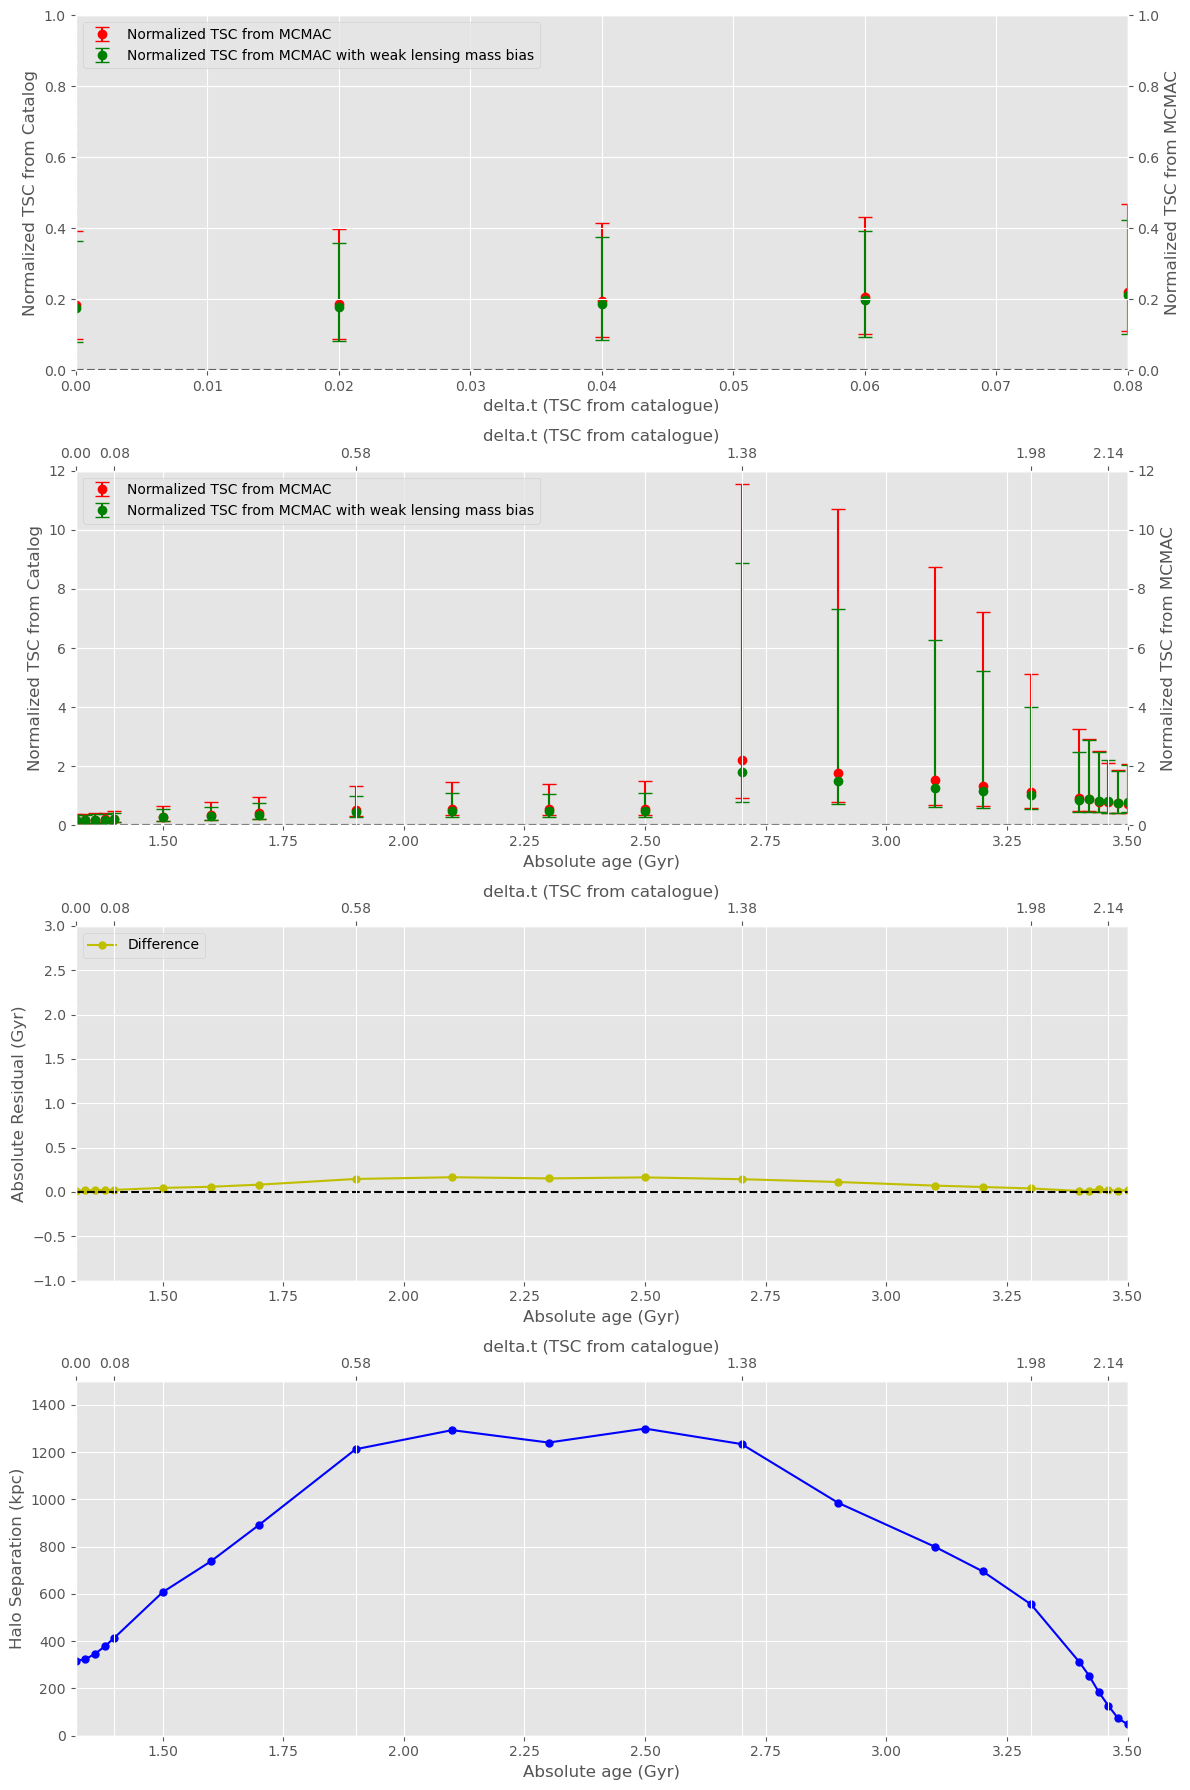

In [9]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to3_b1_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to3_b1_z_MCMAC.txt'

absolute_merge_time = 2.5 - 1.18
period_between_two_merger = 2.18
peak_period = 2.5
second_period = 3.5

zoom_x_range = [0, 0.08]
zoom_y_range = [0, 1]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [-0, 12]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-1, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 1500]

plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:10 b=0kpc

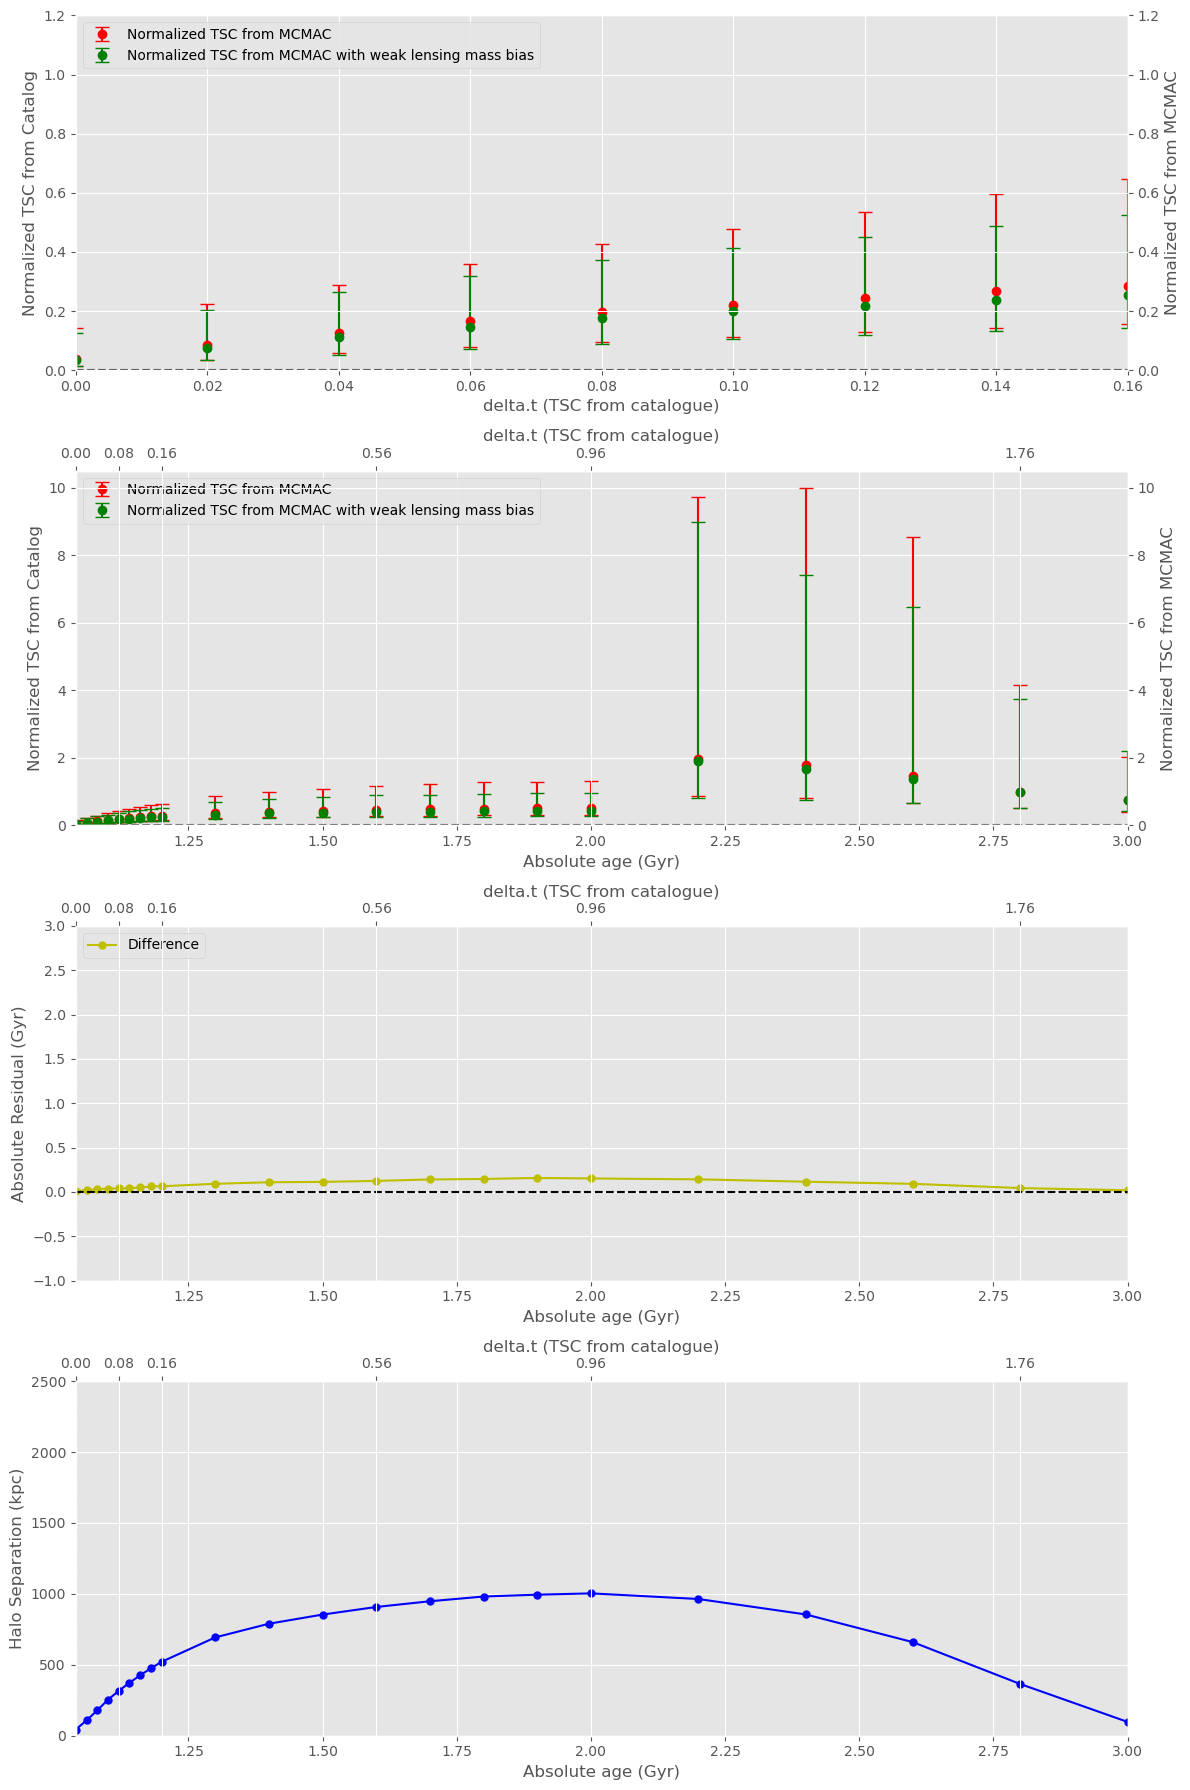

In [10]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to10_b0_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to10_b0_z_MCMAC.txt'

absolute_merge_time = 2 - 0.96
period_between_two_merger = 1.96
peak_period = 2
second_period = 3.0

zoom_x_range = [0, 0.16]
zoom_y_range = [0, 1.2]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 10.5]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-1, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 2500]


plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:10 b=500kpc

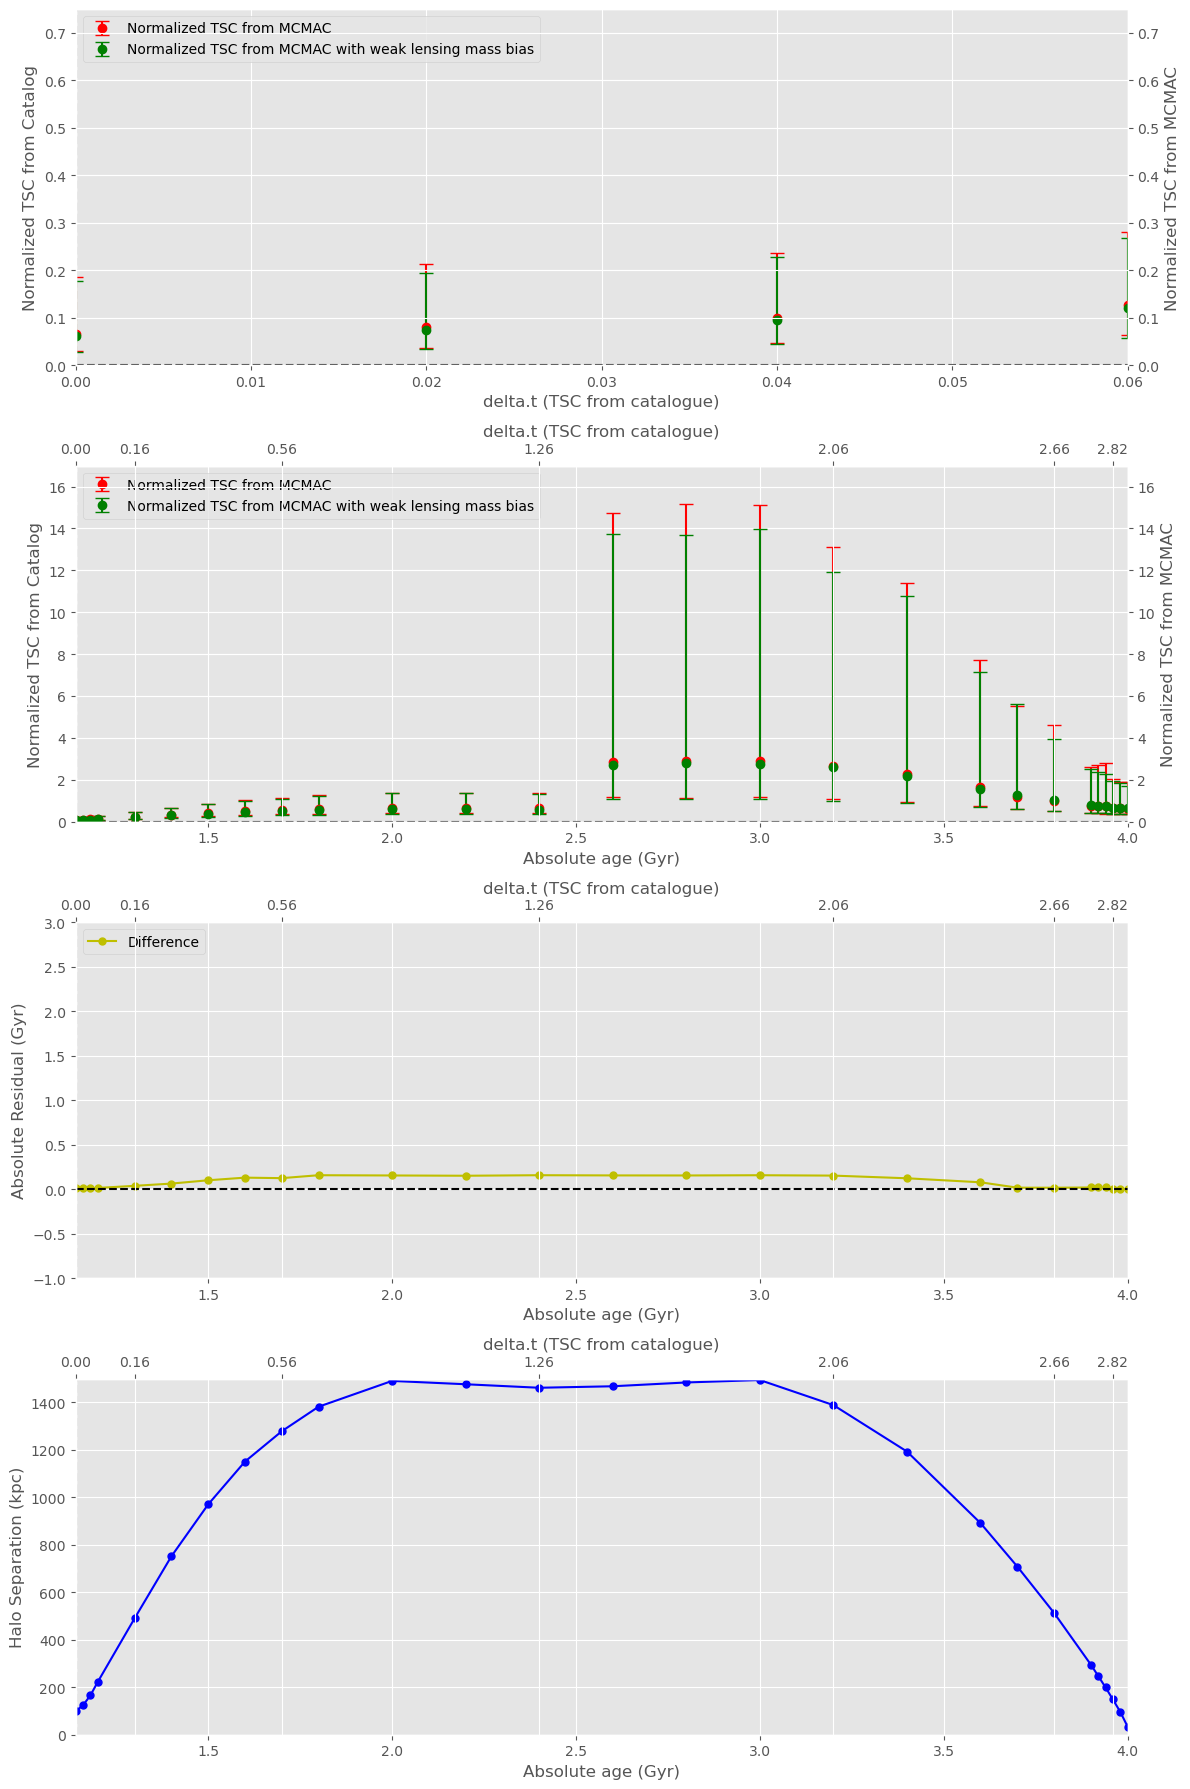

In [11]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to10_b0.5_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to10_b0.5_z_MCMAC.txt'

absolute_merge_time = 2.4 - 1.26
period_between_two_merger = 2.18
peak_period = 2.4
second_period = 4.0

zoom_x_range = [0, 0.06]
zoom_y_range = [0, 0.75]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 17]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-1, 3]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 1500]

plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

## Mass ratio 1:10 b=1000kpc

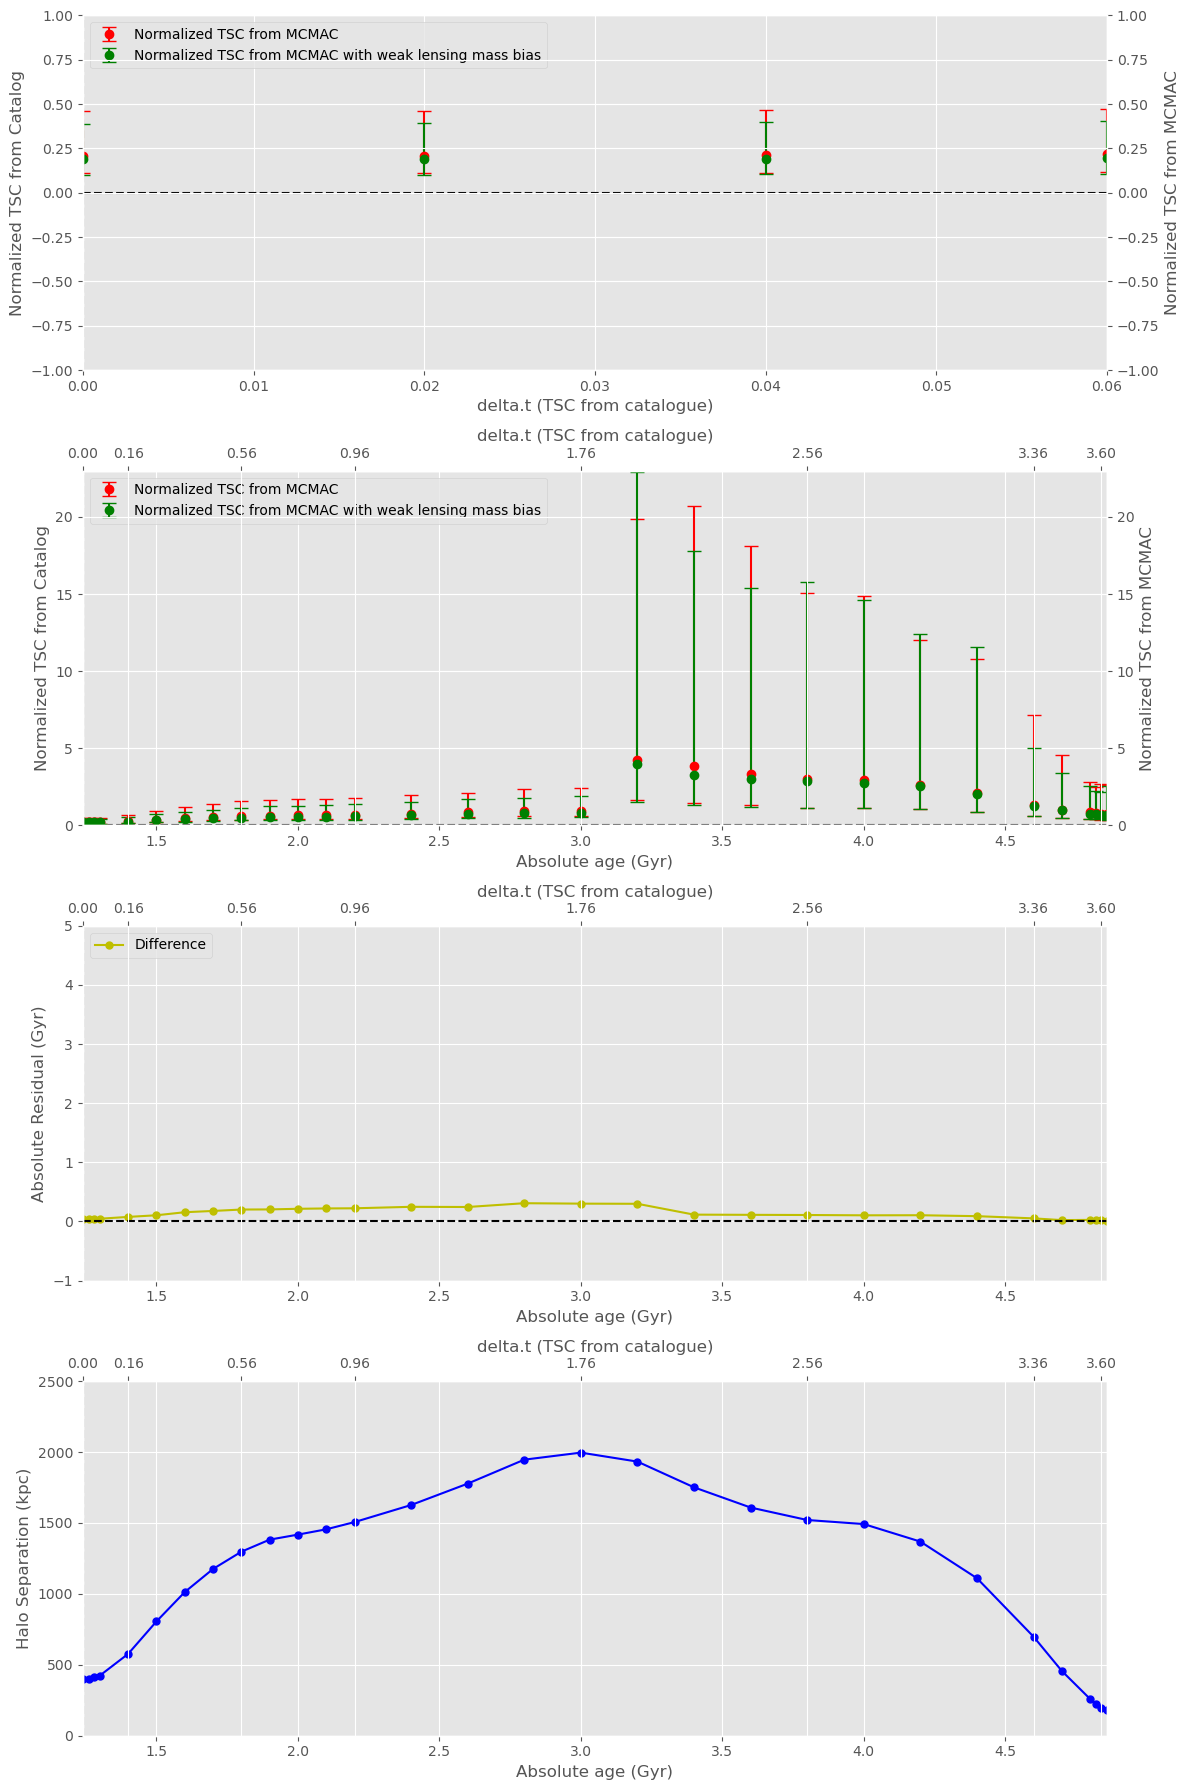

In [12]:

filename_default = '../output_default_2nd_pericentric_passages/zh_1to10_b1_z_MCMAC.txt'
filename_weaklensing = '../output_weaklensing_bias_2nd_pericentric_passages/zh_1to10_b1_z_MCMAC.txt'

absolute_merge_time = 3 - 1.76
period_between_two_merger = 2.18
peak_period = 3
second_period = 4.86

zoom_x_range = [0, 0.06]
zoom_y_range = [-1, 1]
plot1_x_range = [absolute_merge_time, second_period]
plot1_y_range = [0, 23]
plot2_x_range = [absolute_merge_time, second_period]
plot2_y_range = [-1, 5]
plot3_x_range = [absolute_merge_time, second_period]
plot3_y_range = [0, 2500]

plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time, period_between_two_merger, peak_period)

Results for default MCMAC:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.580804,0.696277,-0.798119
1,1:1 (b=0.5),0.549312,0.697482,-0.554319
2,1:1 (b=1),0.676777,0.810075,-0.675640
3,1:3 (b=0),0.622622,0.825457,-0.527566
4,1:3 (b=0.5),0.714415,0.922815,-0.711738
5,1:3 (b=1),0.888245,1.112173,-0.717813
6,1:10 (b=0),0.430520,0.591605,0.023419
7,1:10 (b=0.5),1.067197,1.434052,-0.772713
8,1:10 (b=1),1.181250,1.587001,-0.502184



Results for MCMAC with weak lensing mass bias:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.573933,0.702077,-0.828198
1,1:1 (b=0.5),0.541541,0.694657,-0.541753
2,1:1 (b=1),0.670288,0.822736,-0.728428
3,1:3 (b=0),0.613791,0.822590,-0.516973
4,1:3 (b=0.5),0.705150,0.916837,-0.689630
5,1:3 (b=1),0.880955,1.121606,-0.747077
6,1:10 (b=0),0.399636,0.589511,0.030320
7,1:10 (b=0.5),1.060152,1.441338,-0.790772
8,1:10 (b=1),1.118521,1.587973,-0.504026


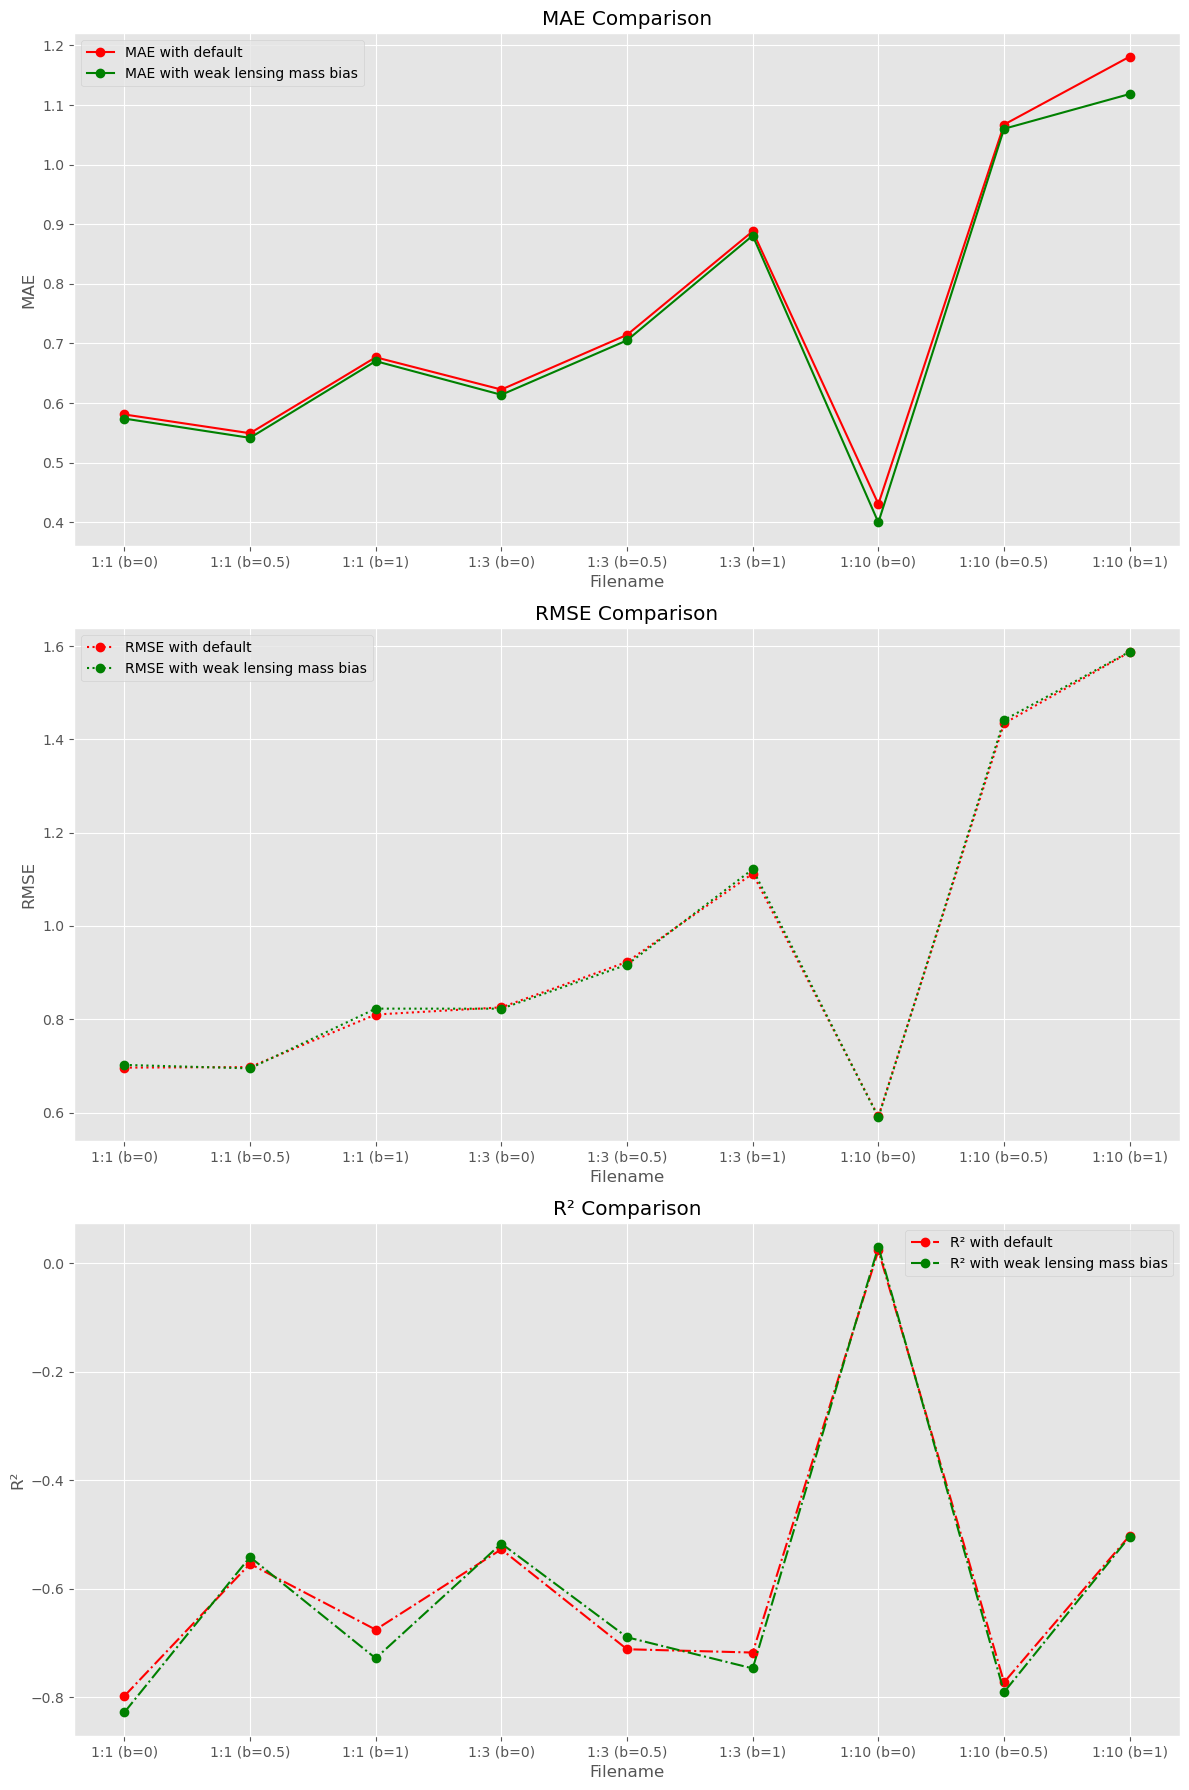

In [13]:
# Convert results lists to dataframes
results_df_default = pd.DataFrame(results_default)
results_df_weaklensing = pd.DataFrame(results_weaklensing)

# Print the dataframes
print("Results for default MCMAC:")
display(results_df_default)
print("\nResults for MCMAC with weak lensing mass bias:")
display(results_df_weaklensing)

# プロットの設定
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# MAEのプロット
axs[0].plot(results_df_default['filename'], results_df_default['MAE'], 'r-', marker='o', label='MAE with default')
# axs[0].plot(results_df_0_60['filename'], results_df_0_60['MAE'], 'b-', marker='o', label='MAE 0-60 degree')
axs[0].plot(results_df_weaklensing['filename'], results_df_weaklensing['MAE'], 'g-', marker='o', label='MAE with weak lensing mass bias')
axs[0].set_title('MAE Comparison')
axs[0].set_xlabel('Filename')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].grid(True)

# RMSEのプロット
axs[1].plot(results_df_default['filename'], results_df_default['RMSE'], 'r:', marker='o', label='RMSE with default')
# axs[1].plot(results_df_0_60['filename'], results_df_0_60['RMSE'], 'b-', marker='o', label='RMSE 0-60 degree')
axs[1].plot(results_df_weaklensing['filename'], results_df_weaklensing['RMSE'], 'g:', marker='o', label='RMSE with weak lensing mass bias')
axs[1].set_title('RMSE Comparison')
axs[1].set_xlabel('Filename')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].grid(True)

# R²のプロット
axs[2].plot(results_df_default['filename'], results_df_default['R²'], 'r-.', marker='o', label='R² with default')
# axs[2].plot(results_df_0_60['filename'], results_df_0_60['R²'], 'b-', marker='o', label='R² 0-60 degree')
axs[2].plot(results_df_weaklensing['filename'], results_df_weaklensing['R²'], 'g-.', marker='o', label='R² with weak lensing mass bias')
axs[2].set_title('R² Comparison')
axs[2].set_xlabel('Filename')
axs[2].set_ylabel('R²')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()